## Pre-process the data

In [28]:
approve = pd.read_csv ("LoanStats_2018Q3.csv", skiprows=1)
reject = pd.read_csv ("RejectStats_2018Q3.csv",skiprows=1)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
#Choose the columns to keep
reject_name = ['Amount Requested','Loan Title','Debt-To-Income Ratio',
               'State','Employment Length','Policy Code']
approve_name = ['loan_amnt', 'title', 'dti', 'addr_state', 'emp_length', 'policy_code']

#Keep the specific columns
reject = reject [reject_name]
approve = approve [approve_name]
approve.columns = ['Amount Requested','Loan Title','Debt-To-Income Ratio','State','Employment Length','Policy Code']

In [30]:
#Clean the accepted: debt-to-ratio income should reduce
approve['Debt-To-Income Ratio'] = approve['Debt-To-Income Ratio']/100
approve['Approved'] = 1

#Clean the rejected data: Change the percentage string to float number
reject['Debt-To-Income Ratio'] = reject['Debt-To-Income Ratio'].str.rstrip('%').astype('float') / 100.0
reject['Approved'] = 0

In [31]:
approve.head()

,Amount Requested,Loan Title,Debt-To-Income Ratio,State,Employment Length,Policy Code,Approved
0,10000.0,Credit card refinancing,0.1922,NJ,10+ years,1.0,1
1,15000.0,Debt consolidation,0.2560,VA,10+ years,1.0,1
2,8500.0,Debt consolidation,0.0633,AZ,2 years,1.0,1
3,35000.0,Debt consolidation,0.1707,NH,4 years,1.0,1
4,28000.0,Debt consolidation,0.1324,CA,10+ years,1.0,1


In [33]:
np.mean(approve['Amount Requested'])

16093.91215657519

In [34]:
np.mean(reject['Amount Requested'])

13475.061193039732

In [32]:
reject.head()

,Amount Requested,Loan Title,Debt-To-Income Ratio,State,Employment Length,Policy Code,Approved
0,3000.0,Debt consolidation,1.0000,CA,< 1 year,0,0
1,40000.0,Major purchase,0.0745,FL,< 1 year,0,0
2,16000.0,Debt consolidation,0.3493,PA,< 1 year,0,0
3,40000.0,Debt consolidation,0.2787,CA,< 1 year,0,0
4,300000.0,Business Loan,-0.0100,TN,< 1 year,0,0


In [15]:
data = pd.concat([approve, reject])

In [16]:
data.shape

(2713441, 7)

In [17]:
#Calculate the number of missing data
null_counts = data.isnull().sum()
print ("Number of missing data is: \n {}".format(null_counts))

Number of missing data is: 
 Amount Requested             2
Loan Title                   2
Debt-To-Income Ratio       309
State                        2
Employment Length       114476
Policy Code                  2
Approved                     0
dtype: int64


In [18]:
#Drop NA data of the columns whose the number of data is too small
data = data.dropna(subset = ['Amount Requested', 'Loan Title', 'State', 'Approved', 'Debt-To-Income Ratio'])

In [19]:
#Replace the ordinal values of employment length into numeric number
#For missing data, I consider that as 0 year experience. 
#This line of thoughts go along with the general thoughts of the audiencce
mapping_dict = {
    "Employment Length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0
    }
}
data = data.replace(mapping_dict)
data['Employment Length'] = data['Employment Length'].fillna(0)

In [20]:
#Convert the nominal values into dummy variables
nominal_columns = ['Loan Title', 'State']
dummy_data = pd.get_dummies (data[nominal_columns])
data = pd.concat ([data, dummy_data], axis = 1)
data = data.drop (nominal_columns, axis = 1)
data.head()

,Amount Requested,Debt-To-Income Ratio,Employment Length,Policy Code,Approved,Loan Title_Business,Loan Title_Business Loan,Loan Title_Car financing,Loan Title_Credit card refinancing,Loan Title_Debt consolidation,...,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,10000.0,0.1922,10.0,1.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,15000.0,0.2560,10.0,1.0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,8500.0,0.0633,2.0,1.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,35000.0,0.1707,4.0,1.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,28000.0,0.1324,10.0,1.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


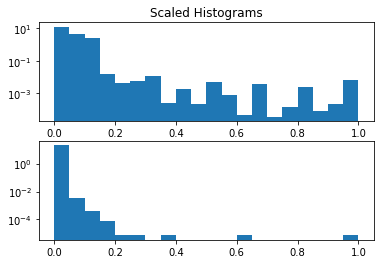

In [21]:
#The high variance in the amount requested might distort the classification task.  
#I will use the min-max scale to normalize the numeric data. 

scaler_1 = MinMaxScaler()
scaler_2 = MinMaxScaler()
scaler_3 = MinMaxScaler()
data['Amount Requested'] = scaler_1.fit_transform(np.array(data['Amount Requested']).reshape(-1,1))
data['Debt-To-Income Ratio'] = scaler_2.fit_transform(np.array(data['Debt-To-Income Ratio']).reshape(-1,1))
data['Employment Length'] = scaler_3.fit_transform(np.array(data['Employment Length']).reshape(-1,1))

plt.subplot(2,1,1)
plt.hist(np.array(data['Amount Requested']), bins=20, density=True, log=True)
plt.title('Scaled Histograms')
plt.subplot(2,1,2)
plt.hist(np.array(data['Debt-To-Income Ratio']), bins=20, density=True, log=True)
plt.show()

In [22]:
data.head()

,Amount Requested,Debt-To-Income Ratio,Employment Length,Policy Code,Approved,Loan Title_Business,Loan Title_Business Loan,Loan Title_Car financing,Loan Title_Credit card refinancing,Loan Title_Debt consolidation,...,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,0.033333,0.000021,1.0,1.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0.050000,0.000027,1.0,1.0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0.028333,0.000008,0.2,1.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0.116667,0.000019,0.4,1.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.093333,0.000015,1.0,1.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Using machine learning to analyze data

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error

In [24]:
#Split the test into training and test set
Train, Test = train_test_split (data, test_size=0.2, random_state=1)

In [25]:
approve = Train[Train['Approved']==1]
reject = Train[Train['Approved']==0]
print('Approval number:', len(approve))
print('Reject number:', len(reject))

Approval number: 102521
Reject number: 2067984


## Using linear regression to predict the maximum amount of money 

In [18]:
#Fit the model and calculate the predicted outcome
approve_target = approve['Amount Requested']
approve_feature = approve.drop(['Amount Requested', 'Approved'], axis = 1)

max_model = LinearRegression()
max_model.fit (approve_feature, approve_target)

pred = max_model.predict(approve_feature)
true_pred = scaler_1.inverse_transform(pred.reshape(-1,1))
origin = scaler_1.inverse_transform(np.array(approve_target).reshape(-1,1))

In [19]:
#Calculate the validity of the model using mse, mae, 
mse = cross_val_score(max_model, approve_feature, approve_target,  cv=3, scoring='mean_squared_error')
mae = cross_val_score(max_model, approve_feature, approve_target,  cv=3, scoring='mean_absolute_error')

print('CV MSE mean:',-np.mean(mse))
print('CV MAE mean:',-np.mean(mae))
print ('True MSE mean,', mean_squared_error(origin, true_pred))
print ('True MAE mean', mean_absolute_error (origin, true_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda3\lib\s

CV MSE mean: 0.0010702110262872475
CV MAE mean: 0.026569343911488238
True MSE mean, 96134960.25093466
True MAE mean 7970.485538100121


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


In [20]:
#Use the prediction to see how the model performs in the rejection set
reject_target = reject['Amount Requested']
reject_feature = reject.drop(['Amount Requested', 'Approved'], axis = 1)
reject_model = max_model.predict(reject_feature)

#Calculate the probability that the predicted amount is larger than the original request
sum(reject_model > reject_target)/len(reject_target)

0.9948713336273395

## Using logistic regression

In [26]:
from sklearn.linear_model import LogisticRegression

#Using 'l2 penalty' instead of 'l1' as I do not want to make the coefficients becomes 0.
classifier = LogisticRegression(penalty='l2')

logistic_target = Train['Approved']
logistic_feature = Train.drop(['Approved'], axis=1)

classifier.fit(logistic_feature, logistic_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [24]:
#Check the performance using cross_validation. 
#CV =2 in order to increase the speed of the classification
accuracy = cross_val_score(classifier, logistic_feature, logistic_target, cv=2, scoring='accuracy')
f1 = cross_val_score(classifier, logistic_feature, logistic_target, cv=2, scoring='f1')
roc_auc = cross_val_score(classifier, logistic_feature, logistic_target, cv=2, scoring='roc_auc')

print('CV accuracy:', np.mean(accuracy))
print('CV f1:', np.mean(f1))
print('CV roc_auc mean:', np.mean(roc_auc))

CV accuracy: 0.9950352567614272
CV f1: 0.9494427275039687
CV roc_auc mean: 0.9916996147150585


## Using KNN for classification

In [21]:
#Split the data due to computational constraint
Train_3, Train_4 = train_test_split (Train, train_size=0.01)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [23]:
from sklearn.neighbors import KNeighborsClassifier

KNN_target = Train_3['Approved']
KNN_feature = Train_3.drop(['Approved'], axis=1)

KNN = KNeighborsClassifier(n_neighbors=3)
KNN.fit(KNN_feature, KNN_target)

KNN_accuracy = cross_val_score(KNN, KNN_feature, KNN_target, cv=2, scoring='accuracy')
KNN_f1 = cross_val_score(KNN, KNN_feature, KNN_target, cv=2, scoring='f1')
KNN_roc_auc = cross_val_score(KNN, KNN_feature, KNN_target, cv=2, scoring='roc_auc')

print('KNN accuracy:', np.mean(KNN_accuracy))
print('KNN f1:', np.mean(KNN_f1))
print('KNN roc_auc mean:', np.mean(KNN_roc_auc))

KNN accuracy: 0.9883437696314203
KNN f1: 0.8679608561261332
KNN roc_auc mean: 0.9479497884853844


## Using K-Means for clustering and classification

In [ ]:
#Using a bigger set of data because K-Means runs faster than KNN classification
Train_1, Train_2 = train_test_split (Train, train_size=0.4)

In [130]:
#First, we may want to know how many clusters we should apply for our model
#Code for finding the optimal k-cluster for K-Means comes from datanovia.com
for k in range (2, 8):
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(Train.iloc[:, :])
    labels = kmeans_model.labels_
    interia = kmeans_model.inertia_
    print ("k:",k, " cost:", interia)

k: 2  cost: 3385567.9746619887
k: 3  cost: 3040911.3697233973
k: 4  cost: 2794981.8980423673
k: 5  cost: 2611959.536186322
k: 6  cost: 2533919.1582933646
k: 7  cost: 2451530.263294253


In [132]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
K_target = Train_1['Approved']
K_feature = Train_1.drop(['Approved'], axis = 1)
K_pred = kmeans.fit_predict(K_feature)

In [134]:
Train_1['K_group'] = K_pred

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [136]:
#Calulate the probability of each group to acknowledge if K-Means could be used for classifications or not
K_group_0 = Train_1[Train_1['K_group']==0][['Approved', 'K_group']]
K_group_1 = Train_1[Train_1['K_group']==1][['Approved', 'K_group']]
K_group_2 = Train_1[Train_1['K_group']==2][['Approved', 'K_group']]
K_group_3 = Train_1[Train_1['K_group']==3][['Approved', 'K_group']]
K_group_4 = Train_1[Train_1['K_group']==4][['Approved', 'K_group']]

prob_0 = len(K_group_0[K_group_0['Approved']==1])/len(K_group_0)
prob_1 = len(K_group_1[K_group_1['Approved']==1])/len(K_group_1)
prob_2 = len(K_group_2[K_group_2['Approved']==1])/len(K_group_2)
prob_3 = len(K_group_3[K_group_3['Approved']==1])/len(K_group_3)
prob_4 = len(K_group_4[K_group_4['Approved']==1])/len(K_group_4)

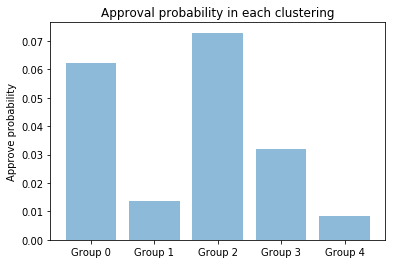

In [137]:
#Plot the histogram of the clustering result
objects = ('Group 0', 'Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5')
y_pos = ([0,1,2,3,4])
y_prob = ([prob_0, prob_1, prob_2, prob_3, prob_4])

plt.bar(y_pos, y_prob, align='center', alpha=0.5)
plt.xticks (y_pos, objects)
plt.ylabel('Approve probability')
plt.title('Approval probability in each clustering')
plt.show()

Because no cluster has a high proportion of the approval probability, K-means clustering does not provide insights into the classification task.

## Test the performance on the hold-out set

In [230]:
Test.head()

,Amount Requested,Debt-To-Income Ratio,Employment Length,Policy Code,Approved,Loan Title_Business,Loan Title_Business Loan,Loan Title_Car financing,Loan Title_Credit card refinancing,Loan Title_Debt consolidation,...,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
1971972,0.031667,0.000104,0.0,0.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2095075,0.050000,0.000030,0.0,0.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
898190,0.026667,0.000003,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
450732,0.033333,0.000002,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
389494,0.016667,0.000034,0.0,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Test the performance of using Logistic Regression to classify the test set

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, roc_auc_score

#Logistics regression 
test_target = Test['Approved']
test_feature = Test.drop (['Approved'], axis = 1)

In [154]:
test_pred = classifier.predict(test_feature)
print ('r2_score :', r2_score(test_target, test_pred))
print ('accuracy score:', accuracy_score(test_target, test_pred))
print ('roc_auc_score:', roc_auc_score(test_target, test_pred))

r2_score : 0.8899927487781512
accuracy score: 0.9950979217768375
roc_auc_score: 0.9911492579634363


### Test the performance of KNN to classify the test set

In [ ]:
KNN_pred = KNN.predict(test_feature)
print ('KNN_r2_score :', r2_score(test_target, KNN_pred))
print ('accuracy score:', accuracy_score(test_target, KNN_pred))
print ('roc_auc_score:', roc_auc_score(test_target, KNN_pred))
#Cannot apply KNN for the test set. Maybe the test set is too large for the KNN to calculate the distance. 

### Test the performance of Linear Regression to predict maximum requested loan for rejected people

In [242]:
#Linear regression 
test_reject = Test[Test['Approved']==0]
test_reject_target = test_reject['Amount Requested']
test_reject_feature = test_reject.drop (['Amount Requested', 'Approved'], axis = 1)

#Predict the model
reject_test_model = max_model.predict(test_reject_feature)

#How many predicted results are larger than the original request of the unseen data? 
sum(reject_test_model > test_reject_target)/len(reject_test_model)

0.994940658584351